In [77]:
# LOADING MODULES

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

from pydoc import help
from scipy.stats.stats import pearsonr

from sklearn import datasets, linear_model
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

from datetime import datetime
from datetime import timedelta
import datetime as dt
import calendar

import math

In [2]:
# !conda install -c conda-forge haversine
# y

In [3]:
# !conda install -c conda-forge/label/gcc7 haversine

In [4]:
# READING TRAINING DATA

train = pd.read_csv('./train.csv', nrows = 1000000)
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

### TASK 1: DATA CLEANING

I performed basic data cleaning which involved:
1. Checking for missing values and removing the rows corresponding to them if any.
2. Removing the rows that have -ve values of Fare amount as Fare cannot be -ve.
3. Truncating longitude and latitude values to fit NY coordinates.

In [5]:
# CHECK FOR NULL ENTRIES
train[pd.isnull(train)].sum()

key                  0.0
fare_amount          0.0
pickup_datetime      0.0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
passenger_count      0.0
dtype: float64

In [6]:
# EXTRACT DATA FROM PICKUP_DATETIME FEATURE IN THE DATASET 

train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S UTC')

#train['pickup_date']= train['pickup_datetime'].dt.date

train['pickup_hour']=train['pickup_datetime'].dt.hour
train['pickup_day']=train['pickup_datetime'].dt.day
train['pickup_month']=train['pickup_datetime'].dt.month
train['pickup_year']=train['pickup_datetime'].dt.year
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

In [7]:
print (train.shape)
print (train.columns)

(1000000, 13)
Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_day_of_week',
       'pickup_month', 'pickup_year'],
      dtype='object')


In [8]:
# REMOVING ENTRIES WITH -VE FARE AMOUNT

train=train.loc[train['fare_amount']>=0]

print (train.shape)

(999962, 13)


##### TRUNCATING THE LONGITUDE AND LATTITUDE COORDINATES BASED ON THAT OF NEW YORK

Used the below link to obtain the Boundary Co-ordinates of New York
https://www.mapdevelopers.com/geocode_bounding_box.php

The boundaries of New York are:  
North Latitude: 40.917577   
South Latitude: 40.477399   
East Longitude: -73.700272   
West Longitude: -74.259090  

Used the above to build a boundary by for the allowed Drop_off and Pick_up Longitude, Latittudes.

This method of data cleaning did not produce substantial results. On analysing the possible reasons for the bad behaviour of the model, I felt that the narrow possible values for the Longitude and Lattitude could be a reason.
To verify the same, I checked the boundaries of the Longitudes and Lattitudes on the Test Data and found that a lot of samples had coordinates outside the above used boundary. 

Inorder to cater to this issue, I used the Test Data to obtain the boundaries on the Lattitude and Longitude.

Which came out to be  
North Latitude: 41.709555   
South Latitude: 40.573143   
East Longitude: -72.986532   
West Longitude: -74.263242  

Created the Boundary using the below values as Test Data contained co-ordinates a bit outside the boundaries specified by the link above.

In [9]:
#Before we  ahead and identify outlier location, let us read the test data and see what the boundaries are.
test =  pd.read_csv('./test.csv')

print("Longitude Boundary in test data")
print (min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max()))

print("Latitude Boundary in test data")
print (min(test.pickup_latitude.min(), test.pickup_latitude.min()),max(test.pickup_latitude.max(), test.pickup_latitude.max()))


Longitude Boundary in test data
-74.263242 -72.986532
Latitude Boundary in test data
40.573143 41.709555


In [10]:
# boundary={'min_lng':-74.263242,
#           'min_lat':40.573143,
#           'max_lng':-72.986532, 
#           'max_lat':41.709555}

boundary={'north_lat':41.709555,
          'south_lat':40.573143,
          'east_long':-72.986532, 
          'west_long':-74.263242}

In [11]:
# train[(train.pickup_latitude==0) | (train.pickup_longitude)==0 | (train.dropoff_latitude==0)|(train.dropoff_longitude==0)].shape

In [12]:
train.loc[~((train.pickup_longitude >= boundary['west_long'] ) & (train.pickup_longitude <= boundary['east_long']) &
            (train.pickup_latitude >= boundary['south_lat']) & (train.pickup_latitude <= boundary['north_lat']) &
            (train.dropoff_longitude >= boundary['west_long']) & (train.dropoff_longitude <= boundary['east_long']) &
            (train.dropoff_latitude >=boundary['south_lat']) & (train.dropoff_latitude <= boundary['north_lat'])),'is_outlier_loc']=1
train.loc[((train.pickup_longitude >= boundary['west_long'] ) & (train.pickup_longitude <= boundary['east_long']) &
            (train.pickup_latitude >= boundary['south_lat']) & (train.pickup_latitude <= boundary['north_lat']) &
            (train.dropoff_longitude >= boundary['west_long']) & (train.dropoff_longitude <= boundary['east_long']) &
            (train.dropoff_latitude >=boundary['south_lat']) & (train.dropoff_latitude <= boundary['north_lat'])),'is_outlier_loc']=0

# print("Outlier vs Non Outlier Counts")
# print(train['is_outlier_loc'].value_counts())

train=train.loc[train['is_outlier_loc']==0]
train.drop(['is_outlier_loc'],axis=1,inplace=True)
print (train.shape)

(978799, 13)


In [13]:
# CALCULATING HAVERSIAN DISTANCE

def haversian_distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

train['hav_distance'] = train.apply(lambda row:haversian_distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

In [14]:
# CALCULATING EUCLEDIAN DISTANCE

train['euc_distance'] = 69 * np.sqrt((np.array(train.dropoff_longitude) - np.array(train.pickup_longitude))**2 + (np.array(train.pickup_latitude) - np.array(train.dropoff_latitude))**2)

In [15]:
print (train.columns)

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'hav_distance', 'euc_distance'],
      dtype='object')


#### WEATHER DATA


Weather Dataset from ​https://www.ncdc.noaa.gov/cdo-web/datasets

○ This website contains the Daily Summaries of the Weather in required cities for the required period of time. And they have the data available from 1869-01-01 until so far.

○ They provide large set of features like Snowfall, Snow Depth, Min Temperature, Max Temperature, Precipitation, Air Wind etc to name a few.

https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf

○ Along with the above details regarding the weather, they provide the year/date/month on which that particular weather was observed. Hence, this can be used to merge this data with our existing data.

○ Weather plays a huge role in the movement of taxis. The availability, prices, and demand everything can change based on the weather. Hence, incorporating details about the weather into our dataset would definitely boost our model.


○ The dataset set used is https://raw.githubusercontent.com/sdaulton/TaxiPrediction/master/data/nyc-weather-data.csv

○ This dataset covers Daily Summary of Weather of New York From Jan 1st 2009 to Nov 11th 2015.


I have again performed basic Pre-processing similar to before.

○ In this dataset -9999 indicate missing values, hence replaced such values with 0

○ Parsed the ‘Date’ feature to extract the following in order to be able to merge this data to our existing data.

■ 'pickup_year'

■ 'pickup_month'

■ 'pickup_day'

○ The provided data was initially parsed to have the above fields. Hence, using these 3 fields, the initial data has been merged with this external Weather Data.

In [16]:
# EXTRACTING FEATURES FROM THE WEATHER DATASET

weather=pd.read_csv("./Weather_Data.csv")

# Replacing Values with -9999 with 0 as they indicate Missing Data
weather.loc[weather.SNWD <= -9999, 'SNWD'] = 0
weather.loc[weather.SNOW <= -9999, 'SNOW'] = 0
weather.loc[weather.AWND <= -9999, 'AWND'] = 0

#Extracting the Year, Month, Day with the same Column Name as that of the Existing Data for Merging
weather['pickup_year'] = (weather['DATE']/10000).apply(math.floor)
weather['pickup_month'] = ((weather['DATE'].mod(10000))/100).apply(math.floor)
weather['pickup_day'] = weather['DATE'].mod(100)
weather = weather[['pickup_year','pickup_month','pickup_day','PRCP','SNWD','SNOW','TMAX','TMIN','AWND']]

# weather['PRCP'] = weather['PRCP'] / 10.
# weather['TMAX'] = weather['TMAX'] / 10.
# weather['TMIN'] = weather['TMIN'] / 10.
# weather['AWND'] = weather['AWND'] / 10. * 3.6
weather.columns = ['pickup_year','pickup_month','pickup_day','precipitation','snow_depth','snowfall','max_temp','min_temp','avg_wind']

In [17]:
# MERGING EXISTING DATA WITH WEATHER DATA TO GENERATE NEW FEATURES

train_new = pd.merge(train, weather, how='left', on=['pickup_year','pickup_month','pickup_day'])

print (train_new.columns)

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'hav_distance', 'euc_distance',
       'precipitation', 'snow_depth', 'snowfall', 'max_temp', 'min_temp',
       'avg_wind'],
      dtype='object')


In [18]:
# CHECKING FOR NULL VALUES

train_new[pd.isnull(train_new)].sum()
print (train_new.dtypes)

key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
pickup_hour                    int64
pickup_day                     int64
pickup_day_of_week            object
pickup_month                   int64
pickup_year                    int64
hav_distance                 float64
euc_distance                 float64
precipitation                  int64
snow_depth                     int64
snowfall                       int64
max_temp                       int64
min_temp                       int64
avg_wind                       int64
dtype: object


In [19]:
# FINAL TRAIN DATA SET THAT WILL BE USED FOR TRAINING AND VALIDATION

train = train_new
print (train.columns)
print (train.shape)
print (train.dtypes)

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'hav_distance', 'euc_distance',
       'precipitation', 'snow_depth', 'snowfall', 'max_temp', 'min_temp',
       'avg_wind'],
      dtype='object')
(978799, 21)
key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
pickup_hour                    int64
pickup_day                     int64
pickup_day_of_week            object
pickup_month                   int64
pickup_year                    int64
hav_distance                 float64
euc_distance                 float64
precipitation                  int

### TASK 2 : PEARSON CORRELATION

2.1) Pearson correlation between Euclidean distance and the taxi fare

● 0.8257585563383683

2.2) Pearson correlation between time of day and distance travelled

● -0.030505480979840977

2.3) Pearson correlation between time of day and the taxi fare

● -0.01927381911008901

In [20]:
print ("Corr between Eucledian Distance and Fare Amount")
corr = pearsonr(train.fare_amount, train.euc_distance)
print (corr)

Corr between Eucledian Distance and Fare Amount
(0.8257585563383683, 0.0)


### TASK 3.1: Plot depicting relationship between 'Distance of the ride' and 'Taxi Fare'

Text(3.8,0.5,'Taxi Fare')

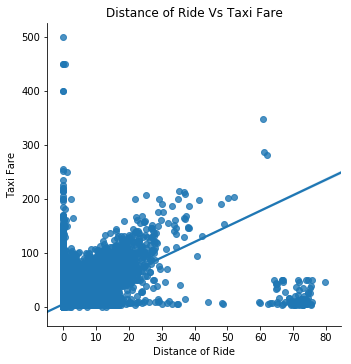

In [120]:
# Scatter Plot Between Eucledian Distance and Fare Amount

sns.lmplot(x='euc_distance', y='fare_amount', data=train)

plt.title('Distance of Ride Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Distance of Ride')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(3.8,0.5,'Taxi Fare')

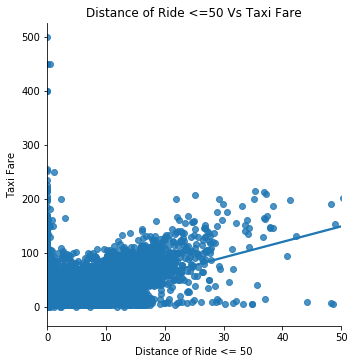

In [122]:
# Scatter Plot Between Eucledian Distance <=50 and Fare Amount

lm = sns.lmplot(x='euc_distance', y='fare_amount', data=train)

lm.set(xlim=(0, 50))
plt.title('Distance of Ride <=50 Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Distance of Ride <= 50')
# Set y-axis label
plt.ylabel('Taxi Fare')

#### Comment on whether you see non-linear or any other interesting relations (based on 3.1)

● In an ideal scenario, we can say that the Distance Travelled and Taxi Fare should be linearly related. But, it is very obvious that there are a lot of external factors that affect the relation between the two and hence we cannot say that they are completely linearly related.

● Although, as we can see in the attached plot there does exist a nearly linear relationship between the two for a lot of data samples. This is more clear in the Right hand side plot which caps the distance travelled to 50.

● One interesting aspect I think could be a depiction of the above plot is that the line describing the data is quite below the y=x line, i.e the fare for higher distances does not increase in proportion to how it does for the distances clustered around the centre.

● This is evident In the left hand side plot where we can see a cluster of data samples at very high distances (60-80) but with quite less fare. This (as previously discussed in class) could be due to the Trips to the Airport which are quite long, but have fixed prices.

● Also, as we know Pearson Correlation depicts the strength of linearity between different parameters. A Pearson Correlation of ​0.8257585563383683 does indicate quite a strong linear correlation between the Distance Travelled and Taxi Fare.


### TASK 3.2: Plot depicting relationship between 'Time of day' and 'Distance Travelled'.

In [22]:
# pickup_hour is distributed from 0-23 for each hour
print ("Corr between Time of the Day and Eucledian Distance")
corr = pearsonr(train.euc_distance, train.pickup_hour)
print (corr)

Corr between Time of the Day and Eucledian Distance
(-0.030505480979840977, 3.470537802458462e-200)


Text(10.05,0.5,'Distance of Ride')

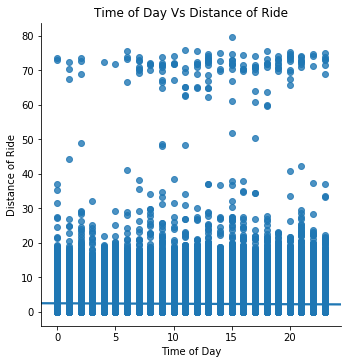

In [105]:
# Scatter Plot Between Eucledian Distance and Time of the Day

sns.lmplot(x='pickup_hour', y='euc_distance', data=train)

plt.title('Time of Day Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Time of Day')
# Set y-axis label
plt.ylabel('Distance of Ride')

#### Comment on whether you see non-linear or any other interesting relations (based on 3.2)

● Based on the attached plot, I see that Time of the Day and Distance travelled are not quite linearly related.

● The Pearson Correlation between the two is very small (​-0.030505480979840977​) which means that they aren’t related much.

● Although, one interesting thing to observe is that there is a range of distances that are mostly never taken despite any part of the day, like the distances between 40-60 are very less taken. And in my assumption, I think that the distances below that could indicate the daily commuters from home to office or vice versa, and the above half could indicate the ones who travel to the airports which tend be quite far away.

● The average distance travelled may be high at the centre (i.e through the day than early or late night) but apart from this, there seems to be no definite linear relationship between time and the distance travelled.

### TASK 3.3: Plot depicting relationship between 'Time of day' and 'Taxi Fare'.

In [24]:
print ("Corr between Time of the Day and Fare Amount")
corr = pearsonr(train.fare_amount, train.pickup_hour)
print (corr)

Corr between Time of the Day and Fare Amount
(-0.01927381911008901, 4.469411432095102e-81)


Text(3.8,0.5,'Taxi Fare')

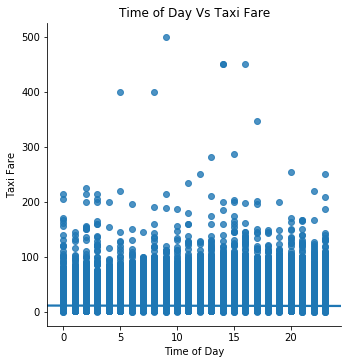

In [106]:
# Scatter Plot Between Fare Amount and Time of the Day

sns.lmplot(x='pickup_hour', y='fare_amount', data=train)

plt.title('Time of Day Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Time of Day')
# Set y-axis label
plt.ylabel('Taxi Fare')

#### Comment on whether you see non-linear or any other interesting relations (based on 3.3)

● In similar line with the above explanation, I see that there does not exist that strong a linear relationship between Time of the Day and Taxi Fare either.

● These are also share a very small Pearson Correlation () indicating that they are not much related as well.

● The interesting aspect about this plot are the data points that lie at high Taxi Fares in the middle of the day, and some at the end of the day. With an assumption that most travel to the airport happens either at early or late hours and with the fact that the fare for these trips is fixed, these anomalous data points would not be of the trips to the airport.

● Instead I feel that the reason for the high fare during midday and later could be due to the increased traffic during that time that could have lead to less available cabs with surged prices, thus leading to some really high data points.

● Apart from that, these two are not as strongly related to each other.

### TASK 4: OTHER INTERESTING PLOTS AND CORRELATIONS BETWEEN CERTAIN FEATURES

In [26]:
# Checking the Correlation between Fare Amount and all other Features

print ("Corr between Fare Amount and all other parameters")
print (train.corr('pearson')["fare_amount"])

Corr between Fare Amount and all other parameters
fare_amount          1.000000
pickup_longitude     0.385422
pickup_latitude     -0.187734
dropoff_longitude    0.302614
dropoff_latitude    -0.152105
passenger_count      0.014255
pickup_hour         -0.019274
pickup_day           0.001666
pickup_month         0.025464
pickup_year          0.116534
hav_distance         0.817532
euc_distance         0.825759
precipitation       -0.005898
snow_depth           0.003205
snowfall            -0.007590
max_temp             0.010604
min_temp             0.010626
avg_wind            -0.022123
Name: fare_amount, dtype: float64


In [27]:
# And, checking the Correlation between Haversian Distance and all other Features

print ("Corr between Haversian Distance and all other parameters")
print (train.corr('pearson')["hav_distance"])

Corr between Haversian Distance and all other parameters
fare_amount          0.817532
pickup_longitude     0.430822
pickup_latitude     -0.151202
dropoff_longitude    0.339358
dropoff_latitude    -0.124345
passenger_count      0.010201
pickup_hour         -0.030179
pickup_day           0.001794
pickup_month         0.013716
pickup_year          0.019573
hav_distance         1.000000
euc_distance         0.993842
precipitation       -0.009177
snow_depth          -0.006396
snowfall            -0.008801
max_temp             0.019485
min_temp             0.018716
avg_wind            -0.014780
Name: hav_distance, dtype: float64


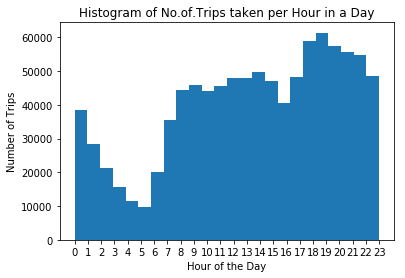

In [32]:
# Histogram of No.of.Trips taken per Hour in a Day

plt.hist(train.pickup_hour, bins=24)
plt.xticks(np.arange(0,24,step=1))
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Histogram of No.of.Trips taken per Hour in a Day')
plt.show()

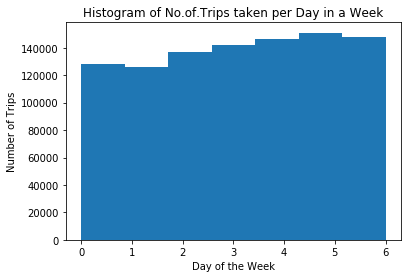

In [54]:
# Histogram of No.of.Trips taken per Day in a Week

def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]
train['pickup_day_of_week']=train['pickup_day_of_week'].apply(lambda x:encodeDays(x))

plt.hist(train.pickup_day_of_week, bins=7)
plt.xticks(np.arange(0,7,step=1))
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Histogram of No.of.Trips taken per Day in a Week')
plt.show()

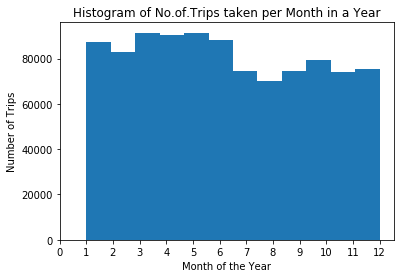

In [35]:
# Histogram of No.of.Trips taken per Month in a Year

plt.hist(train.pickup_month, bins=12)
plt.xticks(np.arange(0,13,step=1))
plt.xlabel('Month of the Year')
plt.ylabel('Number of Trips')
plt.title('Histogram of No.of.Trips taken per Month in a Year')
plt.show()

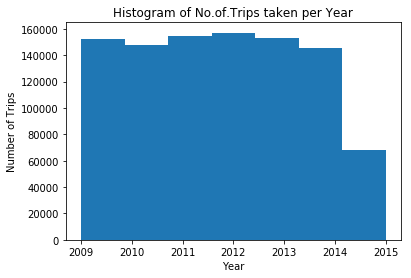

In [36]:
# Histogram of No.of.Trips taken per Year

plt.hist(train.pickup_year, bins=8)
plt.xticks(np.arange(2009,2016,step=1))
plt.xlabel('Year')
plt.ylabel('Number of Trips')
plt.title('Histogram of No.of.Trips taken per Year')
plt.show()

#### PLOTS BETWEEN FARE AMOUNT AND WEATHER CONDITIONS

● The below plots indicate the New parameters that I have used from an External New York Weather Dataset (explained in detail in below questions).

● The parameters are ['avg_wind', 'max_temp', 'min_temp', 'precipitation', 'snow_depth', 'snowfall']. I plotted all these variables against the Fare amount to see how they were related to the two and also to check whether these features would help improve my existing model or not and I found some interesting observations.

Text(3.8,0.5,'Taxi Fare')

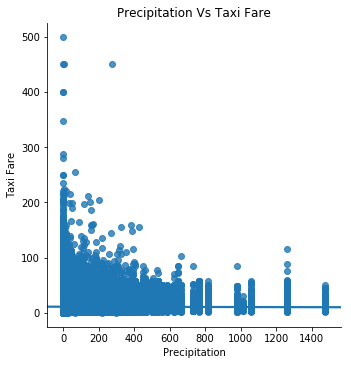

In [123]:
sns.lmplot(x='precipitation', y='fare_amount', data=train)

plt.title('Precipitation Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Precipitation')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(3.8,0.5,'Taxi Fare')

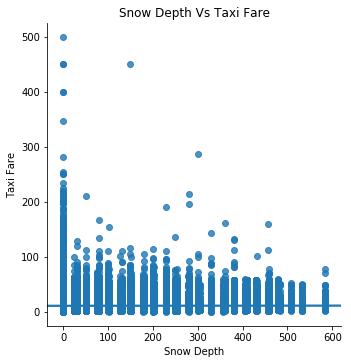

In [108]:
sns.lmplot(x='snow_depth', y='fare_amount', data=train)

plt.title('Snow Depth Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Snow Depth')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(3.8,0.5,'Taxi Fare')

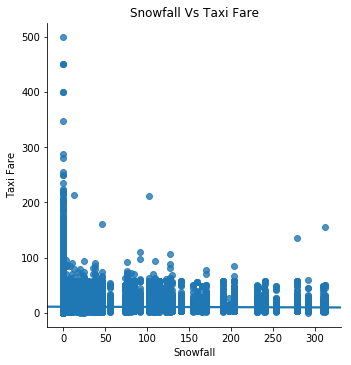

In [109]:
sns.lmplot(x='snowfall', y='fare_amount',data=train)

plt.title('Snowfall Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Snowfall')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(3.8,0.5,'Taxi Fare')

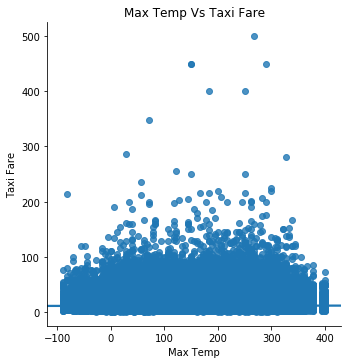

In [110]:
sns.lmplot(x='max_temp', y='fare_amount',data=train)

plt.title('Max Temp Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Max Temp')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(3.8,0.5,'Taxi Fare')

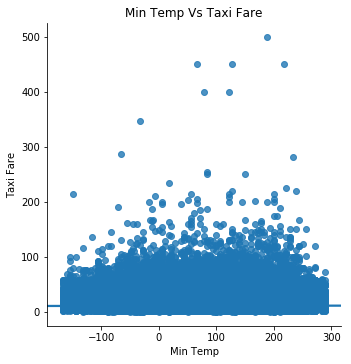

In [111]:
sns.lmplot(x='min_temp', y='fare_amount',data=train)

plt.title('Min Temp Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Min Temp')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(3.8,0.5,'Taxi Fare')

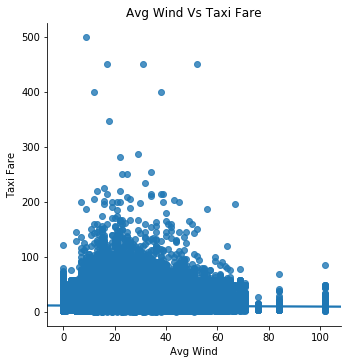

In [112]:
sns.lmplot(x='avg_wind', y='fare_amount', data=train)

plt.title('Avg Wind Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Avg Wind')
# Set y-axis label
plt.ylabel('Taxi Fare')

#### PLOTS BETWEEN TRIP DISTANCE AND WEATHER CONDITIONS

Text(10.05,0.5,'Distance of Ride')

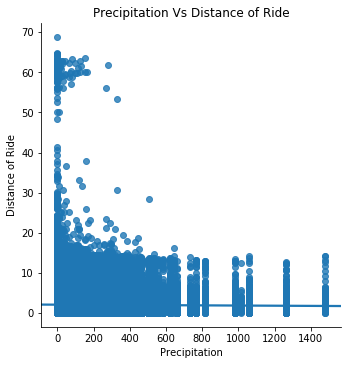

In [113]:
sns.lmplot(x='precipitation', y='hav_distance', data=train)

plt.title('Precipitation Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Precipitation')
# Set y-axis label
plt.ylabel('Distance of Ride')

Text(10.05,0.5,'Distance of Ride')

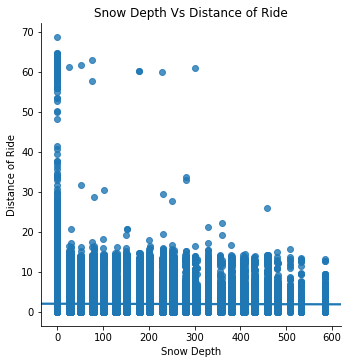

In [114]:
sns.lmplot(x='snow_depth', y='hav_distance', data=train)

plt.title('Snow Depth Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Snow Depth')
# Set y-axis label
plt.ylabel('Distance of Ride')

Text(10.05,0.5,'Distance of Ride')

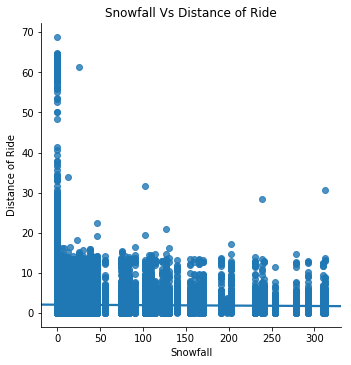

In [115]:
sns.lmplot(x='snowfall', y='hav_distance',data=train)

plt.title('Snowfall Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Snowfall')
# Set y-axis label
plt.ylabel('Distance of Ride')

Text(10.05,0.5,'Distance of Ride')

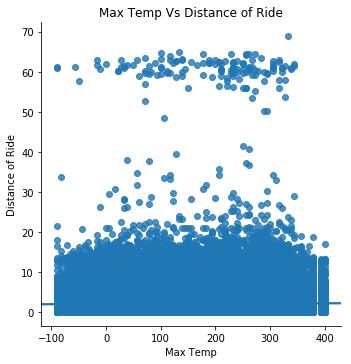

In [119]:
sns.lmplot(x='max_temp', y='hav_distance',data=train)

plt.title('Max Temp Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Max Temp')
# Set y-axis label
plt.ylabel('Distance of Ride')

Text(10.05,0.5,'Distance of Ride')

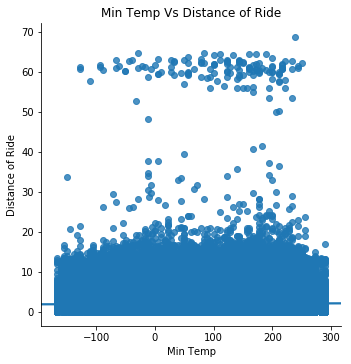

In [117]:
sns.lmplot(x='min_temp', y='hav_distance',data=train)

plt.title('Min Temp Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Min Temp')
# Set y-axis label
plt.ylabel('Distance of Ride')

Text(10.05,0.5,'Distance of Ride')

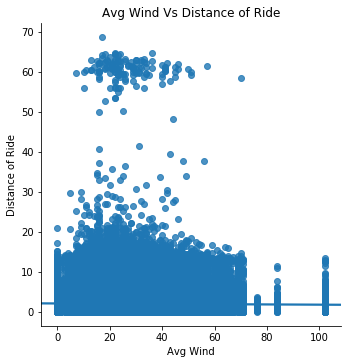

In [118]:
sns.lmplot(x='avg_wind', y='hav_distance', data=train)

plt.title('Avg Wind Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Avg Wind')
# Set y-axis label
plt.ylabel('Distance of Ride')

#### Observations:

Among all the above plots, one common observation I can make is that there is quite a clear relation between the Distance travelled and Taxi Fare, because for the points at the top in the left plots, there are corresponding samples in the right plot as well indicating that Trip Distance and Taxi Fare are indeed correlated.

Now comparing the features one by one:

○ Avg Wind - We can clearly see that for higher winds the distance travelled is lesser,
thus in turn leading the taxi fare to be lesser.

○ Precipitation - Similar to Avg Wind, the distance travelled and the fair are low when
Precipitation is high.

○ Snow Depth and Snow Fall - Here surprisingly I initially expected a decrease in both
the rides and the fairs as I thought the availability of cabs would become lesser. But I see that there is quite a constant curve which could mean that during the snow, people continue to use the cabs all the more due to the harsh weathers.

○ Min Temp and Max Temp - This plot was very interesting indicating perfectly that the distance travelled and taxi fares are high when the temperatures are relatively bearable and they reduced when they go under a certain temperature.

![alt text](./Weather_Data_Vs_TaxiFare_and_DistanceTravelled.jpg "Weather Data Vs Taxi Fare and Distance Travelled")

#### PROCESSING TEST DATA 

In [66]:
# Pre-Processing Test Data

test =  pd.read_csv('./test.csv')
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].dt.day
test['pickup_hour']=test['pickup_datetime'].dt.hour
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_datetime'].dt.month
test['pickup_year']=test['pickup_datetime'].dt.year


test['hav_distance']=test.apply(lambda row:haversian_distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
test['euc_distance'] = 69 * np.sqrt((np.array(test.dropoff_longitude) - np.array(test.pickup_longitude))**2 + (np.array(test.pickup_latitude) - np.array(test.dropoff_latitude))**2)


In [67]:
# Merging with Weather Data to obtain extra Features

test_new = pd.merge(test, weather, how='left', on=['pickup_year','pickup_month','pickup_day'])
print (test_new.columns)

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_date', 'pickup_day', 'pickup_hour', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'hav_distance', 'euc_distance',
       'precipitation', 'snow_depth', 'snowfall', 'max_temp', 'min_temp',
       'avg_wind'],
      dtype='object')


In [68]:
# Checking for NULL Values

test_new[pd.isnull(test_new)].sum()
print (test_new.dtypes)

key                           object
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
pickup_date                   object
pickup_day                     int64
pickup_hour                    int64
pickup_day_of_week            object
pickup_month                   int64
pickup_year                    int64
hav_distance                 float64
euc_distance                 float64
precipitation                  int64
snow_depth                     int64
snowfall                       int64
max_temp                       int64
min_temp                       int64
avg_wind                       int64
dtype: object


In [69]:
# Final Test Set that will be Used For Testing

test = test_new
print (test.columns)
print (test.shape)
print (test.dtypes)

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_date', 'pickup_day', 'pickup_hour', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'hav_distance', 'euc_distance',
       'precipitation', 'snow_depth', 'snowfall', 'max_temp', 'min_temp',
       'avg_wind'],
      dtype='object')
(9914, 21)
key                           object
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
pickup_date                   object
pickup_day                     int64
pickup_hour                    int64
pickup_day_of_week            object
pickup_month                   int64
pickup_year                    int64
hav_distance                 float64
euc_distance                 float64
precipitation                  int64

#### PREPARING TRAIN AND VALIDATION SET FROM TRAINING DATA 

In [124]:
# Considering all the Features except 'Key', 'pickup_date', 'pickup_day_of_week' and 'euc_distance' (as haversian distance is already being considered, and both together could lead to redundant features.)
traindata = train[train.columns[3:]]
traindata = traindata[traindata.columns.difference(['pickup_day_of_week'])]
traindata = traindata[traindata.columns.difference(['pickup_date'])]
traindata = traindata[traindata.columns.difference(['euc_distance'])]

# Trainoutput is the Fare Amount column
trainoutput = train[train.columns[1:2]]

# Considering 2/3rd of the data for Training and 1/3rd for Validation
x, y = traindata.shape
x1 = 2 * int(x / 3)

traindata_X = traindata[0:x1]
testdata_X = traindata[x1:x]

traindata_Y = trainoutput[0:x1]
testdata_Y = trainoutput[x1:x]

x, y
print (traindata.columns)

Index(['avg_wind', 'dropoff_latitude', 'dropoff_longitude', 'hav_distance',
       'max_temp', 'min_temp', 'passenger_count', 'pickup_day', 'pickup_hour',
       'pickup_latitude', 'pickup_longitude', 'pickup_month', 'pickup_year',
       'precipitation', 'snow_depth', 'snowfall'],
      dtype='object')


#### PREPARING TEST DATA

In [125]:
# Considering all Features except 'Key', 'pickup_date', 'pickup_day_of_week'
testdata = test[test.columns[2:]]
testdata = testdata[testdata.columns.difference(['pickup_day_of_week'])]
testdata = testdata[testdata.columns.difference(['pickup_date'])]
testdata = testdata[testdata.columns.difference(['euc_distance'])]

print (testdata.columns)

Index(['avg_wind', 'dropoff_latitude', 'dropoff_longitude', 'hav_distance',
       'max_temp', 'min_temp', 'passenger_count', 'pickup_day', 'pickup_hour',
       'pickup_latitude', 'pickup_longitude', 'pickup_month', 'pickup_year',
       'precipitation', 'snow_depth', 'snowfall'],
      dtype='object')


### TASK 8: PREDICTION MODELS

● I have used 3 Error Metrics to evaluate my models.
    
    ○ Root Mean Square Error (RMSE)
    ○ Mean Squared Error (MSE)
    ○ R2 Score

● And the goal is to try to maximize R2 score (1 being the best) while minimizing RMSE and MSE along with ensuring that the model does not overfit.

● I have tried the following Machine Learning Models:
    
    ○ Linear Regressor
    ○ Decision Trees
    ○ Random Forest Regressor
    ○ XGB Regressor (without any Hyperparameter Tuning) and
    ○ XGB with Hyperparameters

● Among all the above, XGB with Hyperparameters worked the best providing a score of 3.17502 on the Test data. (which is a very high improvement on the Linear Model that was done initially which got a score of 5.60765)

● Also, I tried splitting the data in different proportions to obtain the Train and Validation set and a split of 2/3rd Train and 1/3rd Validation Set along with XGB with Hyperparameters worked the best.


#### LINEAR REGRESSION MODEL

In [126]:
#TRAINING USING LINEAR REGRESSION

regr = linear_model.LinearRegression()
regr.fit(traindata_X, traindata_Y)
testdata_Y_pred_LR = regr.predict(testdata_X)

# The coefficients
print('Coefficients: \n', regr.coef_)

# ERROR METRICS

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, testdata_Y_pred_LR))
print("RMSE: %f" % (rmse))

# The Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, testdata_Y_pred_LR))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, testdata_Y_pred_LR))

Coefficients: 
 [[ 1.60929997e-04 -1.36371540e+01  1.07266298e+01  3.16495014e+00
  -1.10849266e-03  4.61756423e-04  3.70720804e-02  1.90155047e-03
   9.94131511e-03 -2.05127099e+01  1.40138653e+01  7.91423303e-02
   5.36076031e-01  2.81981289e-04  1.78000353e-05 -9.99671939e-04]]
RMSE: 5.255454
Mean squared error: 27.62
Variance score: 0.70


● My Linear regression model achieved an RMSE = ​5.255454, MSE = 27.62 and R2 score = 0.70.

● For a basic linear model (that could be considered as the baseline model) I believe that it did quite okay providing an RMSE = 5.60765 on the Test Data. But, this is definitely not a good model and has to be improved upon.

● Also, I think for data as sparse and vast as that we have, we may not be able to model it linearly as it involves a lot of real world parameters and in general might contain lots of outliers along with many other underlying dependencies among the features. Hence, linear regression did not produce that good a result for the problem.

● Improvisations upon the baseline model have improved the RMSE score for Test Data drastically and this has been discussed further in Que 8.

In [127]:
# TESTING ON TEST USED USING THE ABOVE MODEL

actual_testdata_pred_lr = regr.predict(testdata)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_lr
key.to_csv('test_predictions_lr.csv')

##### USING K-FOLD CROSS VALIDATION

● Instead of manually splitting the data every time, I also performed K-Fold Cross Validation for the different modules. But I did not see significant betterment in the model through this.

● The whole traindata and trainoutput are used here without splitting. K-Fold does the splitting based on K (Here K=6)

Cross validated scores: [0.67103047 0.67908206 0.70298945 0.71866223 0.70759829 0.71236777]
Cross-Predicted Accuracy: 0.6984046393131362


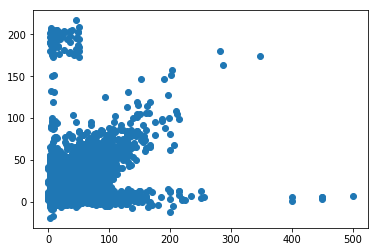

In [78]:
# USING K-FOLD CROSS VALIDATION

scores = cross_val_score(regr, traindata, trainoutput, cv=6)
print ("Cross validated scores:", scores)
    
predictions = cross_val_predict(regr, traindata, trainoutput, cv=6)
plt.scatter(trainoutput, predictions)

accuracy = metrics.r2_score(trainoutput, predictions)
print ("Cross-Predicted Accuracy:", accuracy)

In [79]:
actual_testdata_pred_lr = regr.predict(testdata)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_lr
key.to_csv('test_predictions_lr_cv.csv')

#### DECISION TREE REGRESSOR MODEL

In [137]:
# TRAINING USING DECISION TREE REGRESSOR MODEL

dtr = DecisionTreeRegressor().fit(traindata_X, traindata_Y)
testdata_Y_pred_DTR = dtr.predict(testdata_X)

# Error Metrics

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, testdata_Y_pred_DTR))
print("RMSE: %f" % (rmse))

# Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, testdata_Y_pred_DTR))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, testdata_Y_pred_DTR))


RMSE: 5.733288
Mean squared error: 32.87
Variance score: 0.64


In [138]:
actual_testdata_pred_dtr = dtr.predict(testdata)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_dtr
key.to_csv('test_predictions_dtr.csv')

#### RANDOM FOREST REGRESSOR MODEL

In [128]:
#TRAINING USING RANDOM FOREST REGRESSOR

rf = RandomForestRegressor()
rf.fit(traindata_X, traindata_Y)
testdata_Y_pred_RFR = rf.predict(testdata_X)

# Error Metrics

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, testdata_Y_pred_RFR))
print("RMSE: %f" % (rmse))

# Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, testdata_Y_pred_RFR))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, testdata_Y_pred_RFR))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RMSE: 3.953216
Mean squared error: 15.63
Variance score: 0.83


In [129]:
actual_testdata_pred_rfr = rf.predict(testdata)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_rfr
key.to_csv('test_predictions_rfr.csv')

#### XGB REGRESSOR

In [130]:
#TRAINING USING XGB REGRESSOR

xg_reg = xgb.XGBRegressor()
xg_reg.fit(traindata_X,traindata_Y)
testdata_Y_pred_XGB = xg_reg.predict(testdata_X)

# Error Metrics

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, testdata_Y_pred_XGB))
print("RMSE: %f" % (rmse))

# Mean Square Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, testdata_Y_pred_XGB))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, testdata_Y_pred_XGB))

RMSE: 3.925925
Mean squared error: 15.41
Variance score: 0.83


In [131]:
actual_testdata_pred_xgb = xg_reg.predict(testdata)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_xgb
key.to_csv('test_predictions_xgb.csv')

#### XGB WITH HYPERPARAMETERS

In [132]:
dtrain = xgb.DMatrix(traindata_X, label=traindata_Y)
dtest = xgb.DMatrix(testdata_X)

#set parameters for xgboost
params = {'max_depth':7,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.1
         }
num_rounds = 50

xb = xgb.train(params, dtrain, num_rounds)

y_pred_xgb = xb.predict(dtest)

rmse = np.sqrt(mean_squared_error(testdata_Y, y_pred_xgb))
print("RMSE: %f" % (rmse))

print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, y_pred_xgb))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(testdata_Y, y_pred_xgb))

RMSE: 3.779267
Mean squared error: 14.28
Variance score: 0.84


Tried changing the Parameters to check for better performance

In [133]:
dtrain = xgb.DMatrix(traindata_X, label=traindata_Y)
dtest = xgb.DMatrix(testdata_X)

#Set parameters for xgboost
params = {'max_depth':9,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.1
         }
num_rounds = 100

xb = xgb.train(params, dtrain, num_rounds)

y_pred_xgb = xb.predict(dtest)

# Error Metrics

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, y_pred_xgb))
print("RMSE: %f" % (rmse))

# Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, y_pred_xgb))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, y_pred_xgb))

RMSE: 3.692071
Mean squared error: 13.63
Variance score: 0.85


Tried changing the Parameters again.
##### This gave the best performance among all the previous models.

In [134]:
dtrain = xgb.DMatrix(traindata_X, label=traindata_Y)
dtest = xgb.DMatrix(testdata_X)

#set parameters for xgboost
params = {'max_depth':10,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.15
         }
num_rounds = 100

xb = xgb.train(params, dtrain, num_rounds)

y_pred_xgb = xb.predict(dtest)

# Error Metrics

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, y_pred_xgb))
print("RMSE: %f" % (rmse))

# Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, y_pred_xgb))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, y_pred_xgb))

RMSE: 3.641732
Mean squared error: 13.26
Variance score: 0.86


In [135]:
dtest_actual = xgb.DMatrix(testdata)
actual_testdata_pred_xgb_params = xb.predict(dtest_actual)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_xgb_params
key.to_csv('test_predictions_xgb_params.csv')

Below Plot shows the importance of each feature towards building the Prediction Model.

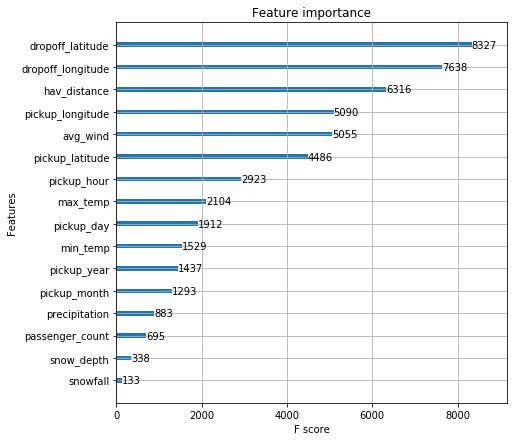

In [136]:
xgb.plot_importance(xb)
plt.rcParams['figure.figsize'] = [7, 7]
plt.show()

### Observations:

● I noted significant change in the performance of my models as I went through from a simple Linear Model to a complex XGB Booster.

● The RMSE score for the different models on the Test Data was as follows:
    
    ○ Linear Regression - RMSE score = 5.60765
    ○ Decision Trees - RMSE score = ​5.88059​ (was worse than Linear Model)
    ○ Random Forest Regressor - RMSE score = ​3.64299​ (drastic improvement from here on)
    ○ XGB Regressor without parameters - RMSE score = ​3.55638
    ○ XGB Regressor with Parameters - RMSE score after tuning the parameters few times = 3.17502

● My understanding from this practice mainly was that real world datasets ( considering most dataset are actually real world) are extremely complicated and visualizing this kind of data in order to understand the data better requires efforts. In other words, a simple linear model is not always sufficient to best model a data BUT should definitely be the way to start as it gives us a better understanding into the data spread and feature dependencies.

● I also understood the concept of ‘Overfitting’ a lot better as I went through multiple training attempts where my Training RMSE was quite impressive but it did not work well on the Test Data Set. Learning Regularization techniques to solve these issues is one thing that I am looking forward to.

● Also, I ran the test on the entire dataset using XGB (without parameters) and it performed way worse than when I consider 1000000 sample (for all my above experiments). I believe this could be due to the fact that there could have been more noise/outliers in the whole set, or that too much data let to extreme overfitting as Train data was 55M while test data was only 9414.
